Properties of the voting population:
    QV is assumed
    500 Voters 
    All Colluders will cooperate
    The Population begins with 50 colluding groups, and no more will spawn
    Colluding Parties will ask 25 voters per election to join them 
    The utilities for each dimension across the population have a mean centered at 0, and have a standard deviation of .3.

In [7]:
import pandas as pd
import numpy as np
import pyparsing as pp
df = pd.read_csv("Quadratic Voting with Collusion Averaged-Collusion-many.csv")

# Define useful functions
# Parses a column of single vectors
parse_single_vector_float = lambda f: \
    f.apply(lambda array: np.fromstring(array[1:-1], sep = ' ', dtype = float))
parse_single_vector_int = lambda f: \
    f.apply(lambda array: np.fromstring(array[1:-1], sep = ' ', dtype = int))

# Returns the nth element of every array in a column
nth_item_float = lambda f, i: \
    f.apply(lambda x: float(x[i]))

# Parses a column of lists of lists
parse_list_of_vectors = lambda column : column.apply(lambda array: pp.nestedExpr('[', ']').parseString(array).asList()[0])


In [8]:
# Clean the df

# Tick 0 data is useless, remove it
df = df[df["Tick"] != 0]

# Parse Vectors
df["Party Sizes"] = parse_single_vector_int(df["Party Sizes"])
df["Payoff"] = parse_single_vector_float(df["Payoff"])
df["Total Advantage"] = parse_single_vector_float(df["Total Advantage"])

c:\users\andreas\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


Text(0.5, 1.0, 'Payoff as a function of number of Elections.  Number of issues: 10')

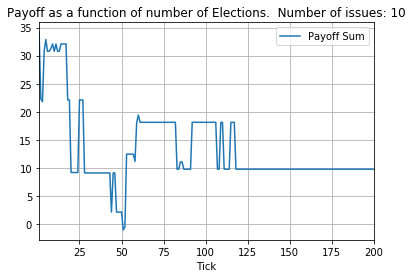

In [31]:
import matplotlib.pyplot as plt

number_of_issues = 10

sample = df[(df["Number of Issues"] == number_of_issues)].sample(n = 1).values[0]
sample = df[df["Run Number"] == sample[0]].sort_values("Tick")
sample = pd.concat([sample, pd.DataFrame(columns = ["Payoff Sum"])])
sample["Payoff Sum"] = sample["Payoff"].apply(lambda x: sum(x))
sample.plot(x = "Tick", y = "Payoff Sum")
plt.grid()
plt.title("Payoff as a function of number of Elections.  Number of issues: " + str(number_of_issues))


Goal 1: How much of the population should collude to tip the vote in their favor?
------
### Note: This dataset is not fit for accomplishing this goal...

In [17]:
# Useful statistics: Number of Colluding members
df_1 = df
df_1 = pd.concat([df_1, pd.DataFrame(columns = ["Number of Colluding Members"])])
df_1["Number of Colluding Members"] = df_1["Party Sizes"].apply(lambda x: sum(x))

# Group by runs
run_groups = df_1.sort_values(["Tick"]).groupby(by = ["Run Number"])

c:\users\andreas\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [23]:
# Find out when each run flips, as a result of collusion

df_critical_collusion = pd.concat([df_1.drop_duplicates(subset = "Run Number"),
                                   pd.DataFrame(columns = ["Last Utility"])
                                   ])

del df_critical_collusion["Party Sizes"]
df_critical_collusion["Tick"] = 0
df_critical_collusion["Number of Colluding Members"] = 0
df_critical_collusion["Payoff"] = 0
df_critical_collusion["Last Utility"] = 0
df_critical_collusion = df_critical_collusion.astype(object)

# Checks if floating point arrays are equal.
# Accounts for rounding and floating point precision error
def arrays_equal(first, second):
    if len(first) !=  len(second):
        return False
    for x, y in zip(first, second):
        if abs (y - x) > .01:
            return False
    return True

# So if an axis flips, its the cause of collusion.  
# (There are no strategic voters, everyone votes according to their utilities)
for name, group in run_groups:
    initial_utility = list(group["Payoff"].values[0])
    index = df_critical_collusion[df_critical_collusion["Run Number"] == group["Run Number"].values[0]].index[0]
    last_row = 0
    for i, row in group.iterrows():
        if not arrays_equal(list(row["Payoff"]), initial_utility):
            df_critical_collusion.loc[index, "Tick"] = row["Tick"]
            df_critical_collusion.loc[index, "Number of Colluding Members"] = row["Number of Colluding Members"]
            df_critical_collusion.loc[index, "Payoff"] = row["Payoff"]
            df_critical_collusion.loc[index, "Last Utility"] = last_row["Payoff"]
            break
        last_row = row
        

c:\users\andreas\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


For the following graphs, the range is quite large. Does the utility play a role in this?

'\nIs this strip plot necessary? \n\nsns.stripplot(\n    x = "Number of Issues", \n    y = "Number of Colluding Members", \n    data = df_critical_collusion.sample(n = 100),\n    jitter=True\n    )\n'

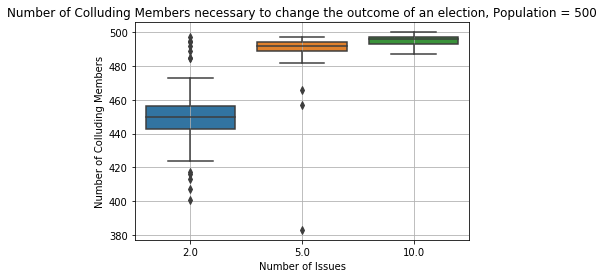

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

df_critical_collusion = df_critical_collusion[df_critical_collusion["Number of Colluding Members"] != 0]
# df_critical_collusion.boxplot(by = "Number of Issues", column = "Number of Colluding Members")

sns.boxplot(
    x = "Number of Issues", 
    y = "Number of Colluding Members", 
    data = df_critical_collusion).set_title("Number of Colluding Members necessary to change the outcome of an election, Population = 500")
plt.grid()

"""
Is this strip plot necessary? 

sns.stripplot(
    x = "Number of Issues", 
    y = "Number of Colluding Members", 
    data = df_critical_collusion.sample(n = 100),
    jitter=True
    )
"""

Goal 3: Whats the average number of collusion groups over time?
------
This should be grouped by number of issues.

In [36]:
issue_counts = [2, 5, 10]
colluding_averages = []
for count in issue_counts:
    df_3 = df[(df["Number of Issues"] == count)]
    average_colluding_groups = pd.DataFrame(columns = ["Tick", "Average Number of Colluding Parties"]).astype(float)
    average_colluding_groups["Tick"] = df_3["Tick"].drop_duplicates().sort_values()
    average_colluding_groups.name = "Average Number of Colluding Groups over time. Number of Issues: " + str(count)
    for index, tick in average_colluding_groups["Tick"].items():
        average_colluding_groups.at[index, "Average Number of Colluding Parties"] = df_3[df_3["Tick"] == tick]["Number of Colluding Parties"].astype(float).agg('mean')
    colluding_averages.append(average_colluding_groups)
    

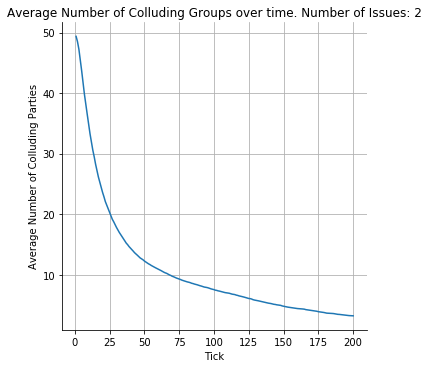

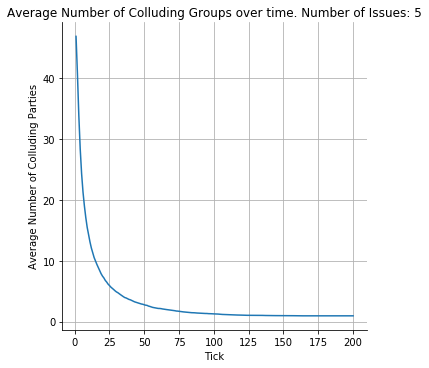

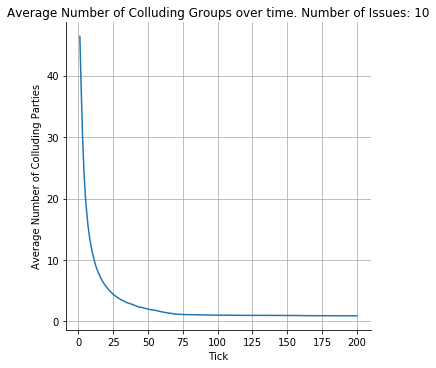

In [42]:
for average_colluding_groups in colluding_averages:
    sns.relplot(x = "Tick", 
                y = "Average Number of Colluding Parties", 
                kind = "line", 
                data = average_colluding_groups
                )
    plt.title(average_colluding_groups.name)
    plt.grid()

Goal 2: What does the average/sum Shapley value need to be to tip the election?
-----
Notes:
The direction is entirely arbitrary, so only direction 0 will be inspected. 
Only elections which have flipped in direction 0 will be inspected.

In [40]:

df_2 = df

df_2 = df_2[df_2["Tick"] != 0]
df_2["Payoff"] = parse_single_vector_float(df_2["Payoff"])
df_2["Party Sizes"] = parse_single_vector_int(df_2["Party Sizes"])

# Passes in group for a single run, returns True if flipped on zero axis, False otherwise.
def flipped_on_zero(group):
    zero_utility = nth_item_float(group["Payoff"], 0)
    first = zero_utility.array[0]
    return not zero_utility.apply(lambda x: abs(x - first) < .1).all()
        
flipped = df_2.groupby(by = "Run Number").filter(lambda g: flipped_on_zero(g))
flipped_run_groups = flipped.groupby(by = "Run Number")

IndexError: index 0 is out of bounds for axis 0 with size 0

In [9]:
from random import random

group = flipped_run_groups.nth(int(random() * len(flipped_run_groups.groups)))
group = pd.concat([group, pd.DataFrame(columns = ["Shapley Values"])])
for i, row in group.iterrows():
    

c:\users\andreas\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until
